In [3]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time
import configparser


save_path = '../Scrittek/figures/'
#I/O 
spectra_filename = 'ARS_14_02'
now_path            =   '../BRILLOUIN/TDP43/' +spectra_filename +'/'

inputs = configparser.ConfigParser()

with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)


############
#I/O 

VIPA_filename       =   inputs['I/O']['VIPA_filename']
log_file            =   'log_'+spectra_filename
transpose           =   inputs.getboolean('I/O', 'transpose')

#operatives
to_add              =   eval(inputs['Operatives']['to_add'])
exclude_delta       =   inputs.getboolean('Operatives', 'exclude_delta')

syg_kwargs          =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs')}
syg_kwargs_VIPA     =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_VIPA')}
syg_kwargs_brill    =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_brill')}
pre_cut             =  inputs.getboolean('Operatives','pre_cut')
pre_cut_range       =  None#eval(inputs['Operatives']['pre_cut_range'])
VIPA_treshold       =  inputs.getfloat('Operatives','VIPA_treshold')
sat_height          =  inputs.getfloat('Operatives','sat_height')
sat_width           =  inputs.getfloat('Operatives','sat_width')
almost_treshold     =  inputs.getfloat('Operatives','almost_treshold')
cut                 =  inputs.getboolean('Operatives','cut')
mean_dist_01        =  inputs.getfloat('Operatives','mean_dist_01')
mean_dist_23        =  inputs.getfloat('Operatives','mean_dist_23')
#markov_fit

recover_markov      = inputs.getboolean('Markov', 'recover_markov')
p0_normal           = np.array(eval(inputs['Markov']['p0_normal']))
p0_almost           = np.array(eval(inputs['Markov']['p0_almost']))

rules_markov_bounds =   eval(inputs['Markov']['rules_markov_bounds'])
#tot fit
skip_tot            =  inputs.getboolean('Tot', 'skip_tot')
rules_tot_bounds    =   eval(inputs['Tot']['rules_tot_bounds'])


############


cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark_nodelta  = ('Co', 'Omega', 'Gamma', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_real_nodelta =  ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'shift', 'offset')

cols_gauss  = ( 'A', 'mu', 'sigma')
print('OK, variabili operative:\npre_cut = {}\ntranspose = {}\nexculde delta = {}\nbounds markov = {}'.format(pre_cut, transpose, exclude_delta, str(rules_markov_bounds)))

OK, variabili operative:
pre_cut = False
transpose = False
exculde delta = True
bounds markov = ('positive', 0.2, 'positive', [-2, 2], 'positive', 'positive', 'positive', 0.01, 0.001, 'inf', 'inf')


ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


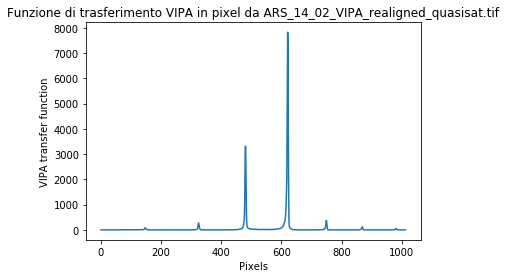

Text(0.5, 1.0, '(70, 50)')

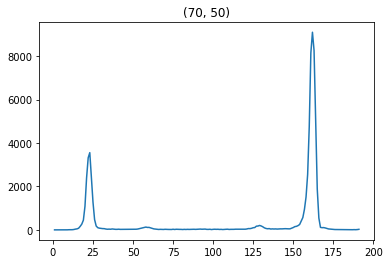

In [4]:
#0) importo dati e inizializzo oggetti
i   =  70
j   =  50
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3', transpose = False)[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = pre_cut_range)
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Lo spettro è normal
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(70, 50)')

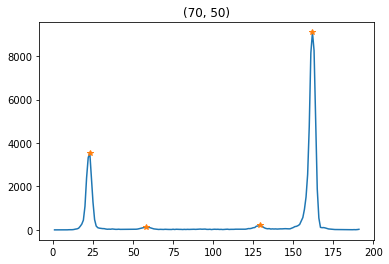

In [5]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'

print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

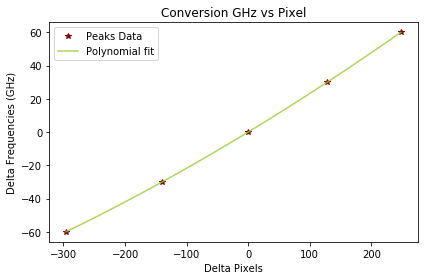

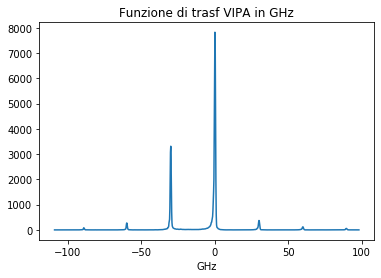

In [6]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True, data_color = 'maroon', fit_color = 'yellowgreen', savepath = save_path)
Data.VIPA_Pix2GHz(fig = True)

In [7]:
"""
# PLOT del FIT gaussiano
f1, ax1 = plt.subplots()
ax1.plot(Data.x_VIPA, Data.y_VIPA, c = 'yellowgreen', alpha = 0.99, label = 'VIPA response function')
pk = find_peaks(Data.y_VIPA, height = 100., width = 1., distance = 100)
ax1.plot(Data.x_VIPA[pk[0]], Data.y_VIPA[pk[0]], '*', c = 'maroon', label = 'peaks')
ax1.xaxis.set_label_text('Delta Pixels')
ax1.yaxis.set_label_text('Intensity (a.u.)')
ax1.legend()
ax1.set_xlim(-400, 400)
plt.tight_layout()
f1.savefig(save_path+'VIPA_peaks.pdf', format = 'pdf')
"""

"\n# PLOT del FIT gaussiano\nf1, ax1 = plt.subplots()\nax1.plot(Data.x_VIPA, Data.y_VIPA, c = 'yellowgreen', alpha = 0.99, label = 'VIPA response function')\npk = find_peaks(Data.y_VIPA, height = 100., width = 1., distance = 100)\nax1.plot(Data.x_VIPA[pk[0]], Data.y_VIPA[pk[0]], '*', c = 'maroon', label = 'peaks')\nax1.xaxis.set_label_text('Delta Pixels')\nax1.yaxis.set_label_text('Intensity (a.u.)')\nax1.legend()\nax1.set_xlim(-400, 400)\nplt.tight_layout()\nf1.savefig(save_path+'VIPA_peaks.pdf', format = 'pdf')\n"

[480 620 748]
[-29.99341793   0.03998866  29.94011587]


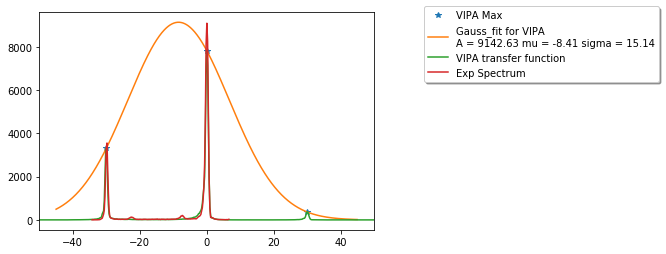

In [24]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive

Data.Align_Spectrum()
Data.Spectrum_Pix2GHz()#fig = True)
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = False, mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23, verbose = True)
Data.Fit_VIPA_Gaussian(fig = True)


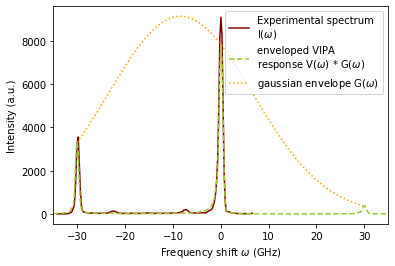

In [40]:
"""
STAMPA PER TESI
from Alessandria import gaussian
f, ax = plt.subplots()
ax.plot(Data.x_freq, Data.y, ls = 'solid', label = 'Experimental spectrum \nI($\omega$)', c = 'maroon')
ax.plot(Data.x_VIPA_freq, Data.y_VIPA, ls = 'dashed' , label = 'enveloped VIPA \nresponse V($\omega$) * G($\omega$)', c = 'yellowgreen')
x = np.linspace(-30,30,1000)
ax.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelope G($\omega$)', c = 'orange', ls = 'dotted')
ax.set_xlim(-35, 35)
ax.legend(loc = 'upper right')
ax.set_xlabel('Frequency shift $\omega$ (GHz)')
ax.set_ylabel('Intensity (a.u.)')
f.savefig('../Scrittek/figures/gauss_envelop.pdf', format = 'pdf')
#_ = Data.Gauss_Convolve_Markovian_Response(Data.p0[list(cols_mark)].values[0], fig = True, compare = True)
"""

Cost before fitting = 11056.662744091802
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1057e+04                                    2.99e+04    
       1              2         1.4191e+03      9.64e+03       5.68e+03       3.86e+03    
       2              3         2.8409e+02      1.14e+03       7.45e+03       1.12e+03    
       3              4         6.8712e+01      2.15e+02       1.14e+04       2.09e+02    
       4              5         3.8770e+01      2.99e+01       4.05e+04       9.13e+02    
       5              6         3.6995e+01      1.78e+00       5.04e+05       2.78e+02    
       6              7         3.6796e+01      1.99e-01       4.76e+05       7.13e+00    
       7              8         3.6787e+01      8.89e-03       2.27e+04       1.53e+00    
       8              9         3.6786e+01      3.69e-04       1.06e+05       3.58e-01    
       9             10         3.6786e+01      1

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.004458,7.404427,0.080794,0.039681,0.095829,0.265541,3.213149e-08,-9.622819,15.824454,-0.072178,9.617586
StdErrs,0.004283,0.043828,0.034617,0.026441,0.022751,0.027468,1.576099e+06,13.391225,22.287994,0.042463,4.228133
Initials,0.010000,7.607433,0.100000,0.000000,0.100000,1.000000,5.678979e+03,-9.720019,15.840295,0.000000,0.000000


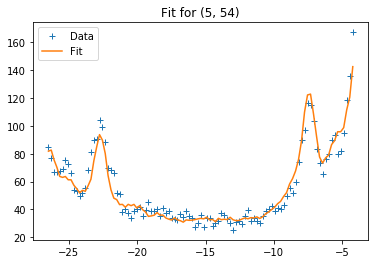

In [62]:
#3) fit markoviano

columns = cols_mark
Data.Get_Fit_Bounds(rules_markov_bounds, columns)

Data.Get_VIPA_for_fit(mode = 'interpolate', interpolation_density = 500)

p0s = [Data.p0[list(columns)].values[0]]#, p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, columns)
Data.Get_cost_markov(Data.p0[list(columns)].values[0], columns = columns)
print('Cost before fitting = {}'.format(Data.cost_markov))


_= Data.Non_Linear_Least_Squares_Markov(columns, fig = True, zoom = False,  bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, method = 'trf',)
#_= Data.Non_Linear_Least_Squares_Markov(columns, verbose = 2, max_nfev = 200, fig = True, zoom = False, method = 'lm')
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = columns)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [63]:
Data.Markov_Fit_Params[list(cols_mark)].values[0]

array([ 4.45785324e-03,  7.40442712e+00,  8.07935070e-02,  3.96812954e-02,
        9.58287799e-02,  2.65541107e-01,  3.21314854e-08, -9.62281912e+00,
        1.58244543e+01, -7.21776390e-02,  9.61758585e+00])

The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 6.4136e+01, final cost 6.2923e+01, first-order optimality 1.63e+01.
s impiegati a fare il fit totale  5.300095665000001 



,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.007798,7.264208,0.114150,0.515955,0.778215,1.289679,0.062760,0.061117,-0.036839,19.320670
StdErrs,0.005992,5.646327,0.101130,30.962799,22.941399,0.013841,0.015745,0.013013,0.023164,2.355035
Initials,0.007630,7.433637,0.126493,0.126493,1.000000,1.289618,0.063124,0.062026,-0.037256,19.207306


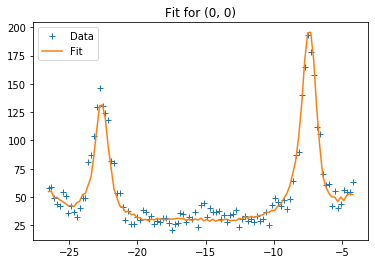

In [9]:
#4) fit totale
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]


columns = cols_real


Data.Initials_Parameters_from_Markov()
Data.Get_Fit_Bounds(rules_tot_bounds, columns)

#_ = Data.Non_Linear_Least_Squares(p_gauss, columns, bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50, method = 'trf')
_ = Data.Non_Linear_Least_Squares(p_gauss, columns, verbose = 2, fig = True, max_nfev = 50, method = 'lm')
Data.Tot_Fit_Params

In [11]:
Data.Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.095943,7.712467,0.157558,-0.012396,0.085955,1.234909e+01,5.223140e+03,-10.049686,15.936516,-0.010159,45.347279
StdErrs,0.384435,0.030102,0.024486,78690.677424,249581.818360,1.533849e+07,5.899682e+09,59.599739,94.140588,0.030762,2.195628
Initials,0.010000,7.259927,0.100000,0.000000,0.100000,1.000000e+00,5.261980e+03,-10.202727,15.976457,0.000000,0.000000
